In [1]:
from PIL import Image
from tensorflow.keras.preprocessing import image as image_
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image_.load_img(img_path, target_size=(224, 224))
        x = image_.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = x / 255
        out.append(x)
    return np.vstack(out)

In [28]:
images = transform_img_fn(['test/test6.jpg'])
images.shape

(1, 224, 224, 3)

In [4]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session =tf.compat.v1.InteractiveSession(config=config)

with tf.device('/CPU:0'):
    model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)

In [74]:
IMAGE_PATH = 'test/test3.jpg'
LAYER_NAME = 'block5_conv3'
CAT_CLASS_INDEX = 281
LAYER_NAME = 'block5_conv3'

In [75]:
img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)

/usr/local/anaconda3/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:792: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [76]:
grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])
grad_model

In [77]:
with tf.device('/CPU:0'):
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.array([img])) #get activations maps + predictions from last conv layer
        loss = predictions[:, CAT_CLASS_INDEX] # the variable loss gets the probability of belonging to the defined class (the predicted class on the 

In [108]:
predictions[:]

<tf.Tensor: shape=(1, 1000), dtype=float32, numpy=
array([[2.73467862e-07, 4.69555346e-08, 5.09519452e-07, 3.41701366e-06,
        7.72143778e-07, 1.16367960e-06, 3.10090456e-07, 2.86833686e-08,
        5.93836305e-08, 6.20286801e-06, 1.13102860e-08, 5.25021200e-08,
        1.31347150e-07, 4.08463080e-07, 3.24989657e-07, 3.27911437e-07,
        6.29209662e-09, 1.73536228e-05, 9.80939774e-08, 2.66780731e-08,
        9.52330268e-08, 4.37696912e-07, 1.74557755e-08, 2.47786744e-07,
        7.11304756e-06, 5.34753752e-08, 7.78304070e-08, 2.70876495e-08,
        2.44060203e-08, 3.90979089e-08, 5.09746130e-08, 1.75075328e-07,
        1.53003938e-08, 4.12356238e-09, 2.93000753e-08, 2.30793972e-07,
        9.45823956e-07, 2.47743486e-07, 3.13544973e-07, 6.95148174e-06,
        8.35111905e-07, 2.02564524e-06, 8.61712763e-08, 3.29234098e-07,
        1.79780927e-05, 1.54371982e-08, 7.33134084e-06, 8.63927880e-08,
        1.60290710e-07, 9.63428306e-08, 2.35952189e-06, 1.26632108e-06,
        7.037

In [116]:
output = conv_outputs[0] #activations maps from last conv layer
print(output.shape)
output

(14, 14, 512)


<tf.Tensor: shape=(14, 14, 512), dtype=float32, numpy=
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          6.7939286 ,  2.4794946 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         25.749146  ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,

In [79]:
loss.numpy()

array([0.5782749], dtype=float32)

In [80]:
with tf.device('/CPU:0'):
    grads = tape.gradient(loss, conv_outputs)[0] #function to obtain gradients from last conv layer

In [81]:
print("grads shape:", grads.shape)
print("Model output (loss for the target class):", loss.shape)
print("Output froom lat conv layer", conv_outputs.shape)

grads shape: (14, 14, 512)
Model output (loss for the target class): (1,)
Output froom lat conv layer (1, 14, 14, 512)


In [82]:
gate_f = tf.cast(output > 0, 'float32')
gate_r = tf.cast(grads > 0, 'float32')

In [118]:
guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

In [119]:
weights = tf.reduce_mean(guided_grads, axis=(0, 1))

In [120]:
cam = np.ones(output.shape[0: 2], dtype = np.float32)

In [122]:

for i, w in enumerate(weights):
    cam += w * output[:, :, i]
    
cam

<tf.Tensor: shape=(14, 14), dtype=float32, numpy=
array([[1.0067949, 1.005347 , 1.005578 , 1.0034547, 1.0046418, 1.0096815,
        1.0121562, 1.0113747, 1.01103  , 1.0110936, 1.013298 , 1.0145004,
        1.0050895, 1.0105479],
       [1.0034857, 1.0021017, 1.0038493, 1.0046363, 1.0087638, 1.0102913,
        1.0118148, 1.0095992, 1.0071981, 1.007577 , 1.010289 , 1.011173 ,
        1.0028527, 1.0049798],
       [1.0075228, 1.0080948, 1.0165906, 1.0144031, 1.012666 , 1.0096526,
        1.0095825, 1.0084217, 1.006052 , 1.0077057, 1.0101233, 1.0140743,
        1.0034847, 1.0063384],
       [1.0070453, 1.010149 , 1.0169551, 1.0136688, 1.0115213, 1.0077894,
        1.0063038, 1.0044572, 1.0038037, 1.0057316, 1.0079544, 1.0092549,
        1.0014014, 1.0035512],
       [1.0086582, 1.0118775, 1.0185659, 1.0132065, 1.0102437, 1.0054121,
        1.0044911, 1.0026639, 1.0037572, 1.0063553, 1.0102949, 1.011333 ,
        1.0015604, 1.003108 ],
       [1.0079856, 1.0095251, 1.0153494, 1.0104172, 1.0

In [87]:
cam = cv.resize(cam.numpy(), (224, 224))

In [88]:
cam = np.maximum(cam, 0)

In [89]:
heatmap = (cam - cam.min()) / (cam.max() - cam.min())

In [90]:
cam = cv.applyColorMap(np.uint8(255*heatmap), cv.COLORMAP_JET)

In [91]:
output_image = cv.addWeighted(cv.cvtColor(img.astype('uint8'), cv.COLOR_RGB2BGR), 0.5, cam, 1, 0)

In [92]:
cv.imwrite('cam.png', output_image)

True

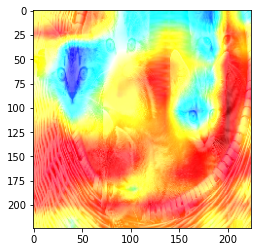

In [93]:
plt.imshow(output_image)

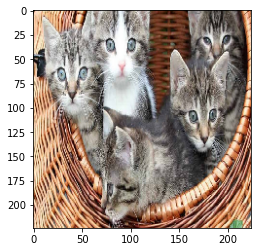

In [94]:
plt.imshow(img.astype('uint8'))

In [114]:
with tf.device('/CPU:0'):
    print(model.predict(np.array([img])).shape)
    print(max(max(model.predict(np.array([img])))))
    print(model.predict(np.array([img])))

(1, 1000)
0.5782749
[[2.73467862e-07 4.69555346e-08 5.09519452e-07 3.41701366e-06
  7.72143778e-07 1.16367960e-06 3.10090456e-07 2.86833686e-08
  5.93836305e-08 6.20286801e-06 1.13102860e-08 5.25021200e-08
  1.31347150e-07 4.08463080e-07 3.24989657e-07 3.27911437e-07
  6.29209662e-09 1.73536228e-05 9.80939774e-08 2.66780731e-08
  9.52330268e-08 4.37696912e-07 1.74557755e-08 2.47786744e-07
  7.11304756e-06 5.34753752e-08 7.78304070e-08 2.70876495e-08
  2.44060203e-08 3.90979089e-08 5.09746130e-08 1.75075328e-07
  1.53003938e-08 4.12356238e-09 2.93000753e-08 2.30793972e-07
  9.45823956e-07 2.47743486e-07 3.13544973e-07 6.95148174e-06
  8.35111905e-07 2.02564524e-06 8.61712763e-08 3.29234098e-07
  1.79780927e-05 1.54371982e-08 7.33134084e-06 8.63927880e-08
  1.60290710e-07 9.63428306e-08 2.35952189e-06 1.26632108e-06
  7.03767398e-07 3.65815644e-08 2.26704799e-07 5.96785128e-08
  9.67663638e-09 4.67126497e-08 1.62304491e-06 2.94022897e-07
  1.01807086e-06 1.07149773e-07 2.53518692e-07 2.9

In [60]:
images[0].shape

(224, 224, 3)

In [112]:
with tf.device('/CPU:0'):
    a = tf.keras.applications.vgg16.decode_predictions(model.predict(np.array([img])), top=5)


In [113]:
a

[[('n02123045', 'tabby', 0.5782749),
  ('n02123159', 'tiger_cat', 0.1536458),
  ('n02124075', 'Egyptian_cat', 0.06763211),
  ('n03950228', 'pitcher', 0.033634607),
  ('n04447861', 'toilet_seat', 0.032017022)]]

In [102]:
np.array([img]).shape

(1, 224, 224, 3)

In [101]:
images.shape

(1, 224, 224, 3)